In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error


import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [2]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


def split_data_b( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям**

In [3]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data_week = data['PJME_MW'].resample('1W').mean()

In [4]:
data_week = pd.DataFrame(data_week)

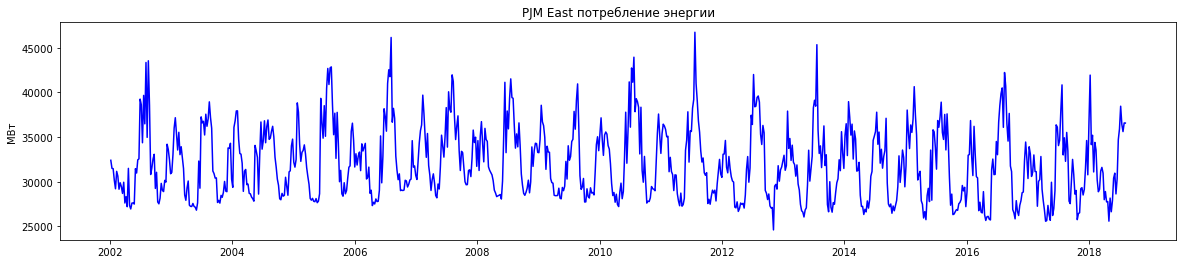

In [5]:
plt.figure(figsize =(20,4))
plt.plot( data_week.index, data_week, 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

In [6]:
data_week['date'] = data_week.index

In [7]:
data_week['year'] = data_week['date'].dt.year
data_week['month'] = data_week['date'].dt.month
data_week['quarter'] = data_week['date'].dt.quarter

In [8]:
data_week.drop( columns = 'date', inplace = True )

In [9]:
df = data_week.copy() 

In [10]:
df['t1'] = 0
df['t2']=0
df['t3']=0

df.iloc[1:,4]=df.iloc[:-1,0].values
df.iloc[2:,5]=df.iloc[:-2,0].values
df.iloc[3:,6]=df.iloc[:-3,0].values

df.fillna(0)

# добавили сглаживание (4 вида - просто для коллекции)
df['exp_0_01'] = exponential_smoothing(df['t1'], 0.01)
df['exp_0_03'] = exponential_smoothing(df['t1'], 0.03)
df['exp_0_05'] = exponential_smoothing(df['t1'], 0.05)
df['exp_0_08'] = exponential_smoothing(df['t1'], 0.08)

In [11]:
df.tail()

,PJME_MW,year,month,quarter,t1,t2,t3,exp_0_01,exp_0_03,exp_0_05,exp_0_08
Date,,,,,,,,,,,
2018-07-08,38459.982143,2018,7,3,35911.839286,34711.648810,30316.940476,31069.852769,30742.857165,30638.435968,30594.670754
2018-07-15,36420.035714,2018,7,3,38459.982143,35911.839286,34711.648810,31143.754063,30974.370915,31029.513277,31223.895665
2018-07-22,35612.095238,2018,7,3,36420.035714,38459.982143,35911.839286,31196.516879,31137.740859,31299.039399,31639.586869
2018-07-29,36581.821429,2018,7,3,35612.095238,36420.035714,38459.982143,31240.672663,31271.971490,31514.692191,31957.387539
2018-08-05,36568.804124,2018,8,3,36581.821429,35612.095238,36420.035714,31294.084151,31431.266988,31768.048653,32327.342250


In [12]:
train, test = split_data_b(df, '2018-07-08')

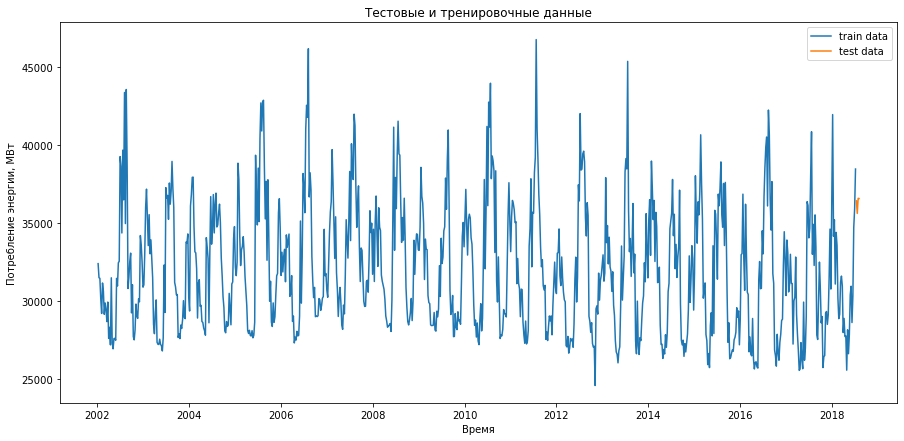

In [13]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [14]:
target = 'PJME_MW'
features = ['year', 'month', 'quarter', 't1', 't2', 't3', 'exp_0_01', 'exp_0_03', 'exp_0_05', 'exp_0_08']

**2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .**

In [15]:
model_gb = GradientBoostingRegressor(max_depth=15, random_state=0, n_estimators=100)

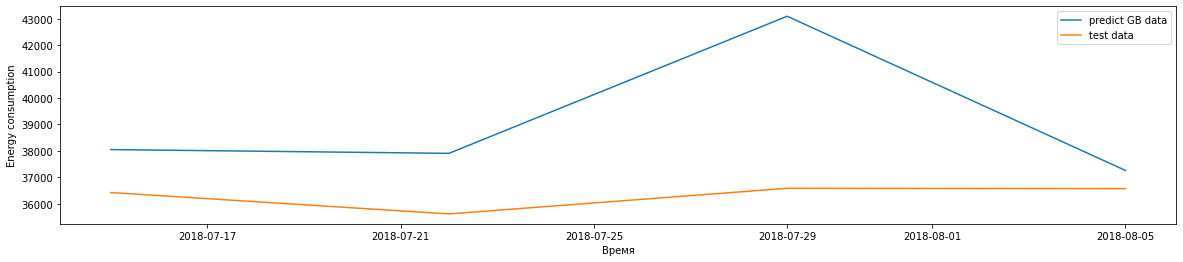

ошибка градиентного бустинга :   7.650482466273807 %


In [16]:
h=4
X_train_b = train[features].iloc[h:]
y_train_b = train[target].values[h:]
X_test_b = test[features].iloc[-h:]
y_test_b = test[target].iloc[-h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Energy consumption')

plt.plot(X_test_b.index[:h],X_test_pred_gb, label='predict GB data')
plt.plot(y_test_b.index[:h],y_test_b, label='test data')


plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

In [17]:
X_test_b

,year,month,quarter,t1,t2,t3,exp_0_01,exp_0_03,exp_0_05,exp_0_08
Date,,,,,,,,,,
2018-07-15,2018,7,3,38459.982143,35911.839286,34711.648810,31143.754063,30974.370915,31029.513277,31223.895665
2018-07-22,2018,7,3,36420.035714,38459.982143,35911.839286,31196.516879,31137.740859,31299.039399,31639.586869
2018-07-29,2018,7,3,35612.095238,36420.035714,38459.982143,31240.672663,31271.971490,31514.692191,31957.387539
2018-08-05,2018,8,3,36581.821429,35612.095238,36420.035714,31294.084151,31431.266988,31768.048653,32327.342250


In [18]:
y_test_b

Date
2018-07-15    36420.035714
2018-07-22    35612.095238
2018-07-29    36581.821429
2018-08-05    36568.804124
Freq: W-SUN, Name: PJME_MW, dtype: float64

In [19]:
X_test_pred_gb

array([38047.88679095, 37905.19725901, 43094.90731172, 37259.58957743])

**3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.**

In [20]:
h=1
X_train_b = train[features].iloc[h:]
y_train_b = train[target].values[h:]
X_test_b = test[features].iloc[-h:]
y_test_b = test[target].iloc[-h:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)


er_g = mean_absolute_percentage_error(y_true=y_test_b, y_pred=X_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

ошибка градиентного бустинга :   2.64636153156128 %


In [21]:
X_test_b

,year,month,quarter,t1,t2,t3,exp_0_01,exp_0_03,exp_0_05,exp_0_08
Date,,,,,,,,,,
2018-08-05,2018,8,3,36581.821429,35612.095238,36420.035714,31294.084151,31431.266988,31768.048653,32327.34225


In [22]:
y_test_b

Date
2018-08-05    36568.804124
Freq: W-SUN, Name: PJME_MW, dtype: float64

In [23]:
X_test_pred_gb

array([37536.54688859])

**4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.**

In [24]:
results = []

X_train_b = train[features].iloc[1:]
y_train_b = train[target].values[1:]
X_test_b = test[features].iloc[-1:]
y_test_b = test[target].iloc[-1:]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

results.append(X_test_pred_gb[0])

for i in range(3):
    
    X_test_b['date'] = X_test_b.index
        
    new_vector = {
    'date':X_test_b['date'] + np.timedelta64(1, 'W'), 
    'year':(X_test_b['date'] + np.timedelta64(1, 'W')).dt.year,
    'month':(X_test_b['date'] + np.timedelta64(1, 'W')).dt.month,
    'quarter':(X_test_b['date'] + np.timedelta64(1, 'W')).dt.quarter,
    't1':X_test_pred_gb[0],
    't2':X_test_b['t1'][0],
    't3':X_test_b['t2'][0],
    'exp_0_01':X_test_pred_gb[0] * (1-0.01) + 0.01 * X_test_b['exp_0_01'],
    'exp_0_03':X_test_pred_gb[0] * (1-0.03) + 0.03 * X_test_b['exp_0_03'],
    'exp_0_05':X_test_pred_gb[0] * (1-0.05) + 0.05 * X_test_b['exp_0_05'],
    'exp_0_08':X_test_pred_gb[0] * (1-0.08) + 0.08 * X_test_b['exp_0_08']   
    }
    
    X_test_b = pd.DataFrame(new_vector)
    
    X_test_b.set_index('date', inplace = True) 
    
    X_test_pred_gb = model_gb.predict(X_test_b)
    
    results.append(X_test_pred_gb[0])
    
results = np.array(results)

In [25]:
results

array([37536.54688859, 33689.87452529, 36880.33556961, 33705.22191517])

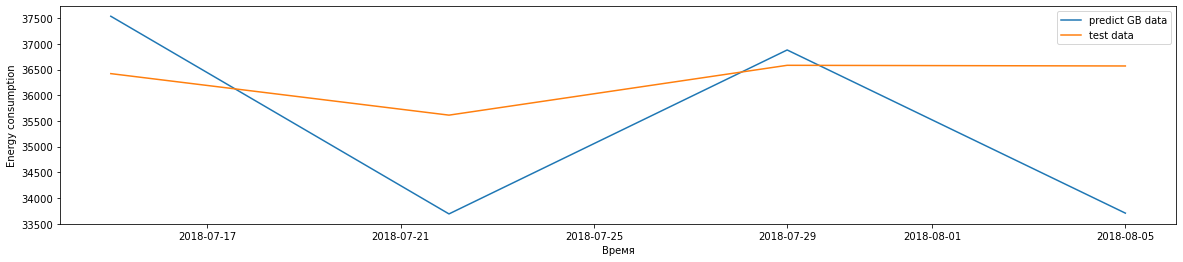

ошибка градиентного бустинга :   4.277500180895315 %


In [26]:
plt.figure( figsize=( 20, 4 ))

plt.xlabel('Время')
plt.ylabel('Energy consumption')

plt.plot(test[target].iloc[-4:].index, results, label='predict GB data')

plt.plot(test[target].iloc[-4:].index, test[target].iloc[-4:], label='test data')


plt.legend()
plt.show()

er_g = mean_absolute_percentage_error(y_true=test[target].iloc[-4:], y_pred=results)

print('ошибка градиентного бустинга :  ', er_g, '%')

**5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреднение по десяткам точек)**

In [27]:
train, test = split_data_b(df, '2016-09-06')

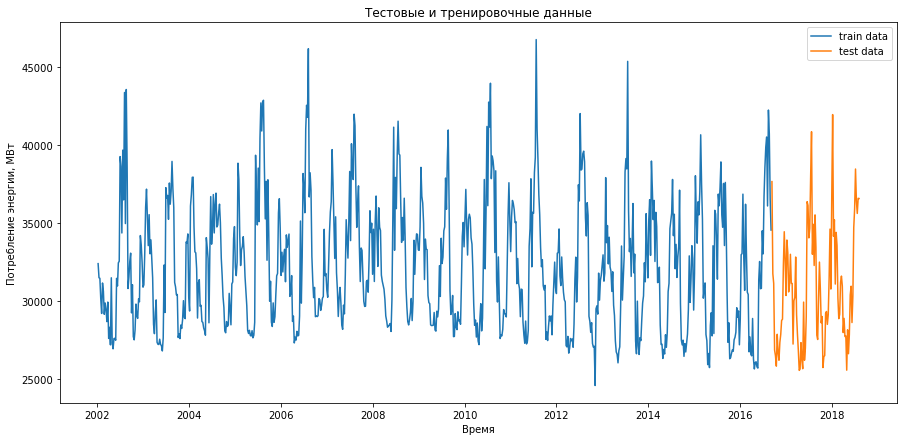

In [28]:
plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(train.index.get_level_values('Date'),train['PJME_MW'], label='train data' )
plt.plot(test.index.get_level_values('Date'),test['PJME_MW'], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.legend()
plt.show()

In [29]:
test

,PJME_MW,year,month,quarter,t1,t2,t3,exp_0_01,exp_0_03,exp_0_05,exp_0_08
Date,,,,,,,,,,,
2016-09-11,37651.392857,2016,9,3,34545.386905,36517.934524,40717.339286,31809.101192,32278.689220,33078.639809,34316.912754
2016-09-18,31751.065476,2016,9,3,37651.392857,34545.386905,36517.934524,31867.524108,32439.870330,33307.277461,34583.671162
2016-09-25,31124.398810,2016,9,3,31751.065476,37651.392857,34545.386905,31866.359522,32419.206184,33229.466862,34357.062707
2016-10-02,26852.815476,2016,10,4,31124.398810,31751.065476,37651.392857,31858.939915,32380.361963,33124.213460,34098.449595
2016-10-09,26487.976190,2016,10,4,26852.815476,31124.398810,31751.065476,31808.878670,32214.535568,32810.643560,33518.798866
...,...,...,...,...,...,...,...,...,...,...,...
2018-07-08,38459.982143,2018,7,3,35911.839286,34711.648810,30316.940476,31069.852769,30742.857165,30638.435968,30594.670754
2018-07-15,36420.035714,2018,7,3,38459.982143,35911.839286,34711.648810,31143.754063,30974.370915,31029.513277,31223.895665
2018-07-22,35612.095238,2018,7,3,36420.035714,38459.982143,35911.839286,31196.516879,31137.740859,31299.039399,31639.586869


In [30]:
test[features].iloc[1:2]

,year,month,quarter,t1,t2,t3,exp_0_01,exp_0_03,exp_0_05,exp_0_08
Date,,,,,,,,,,
2016-09-18,2016,9,3,37651.392857,34545.386905,36517.934524,31867.524108,32439.87033,33307.277461,34583.671162


In [31]:
test[target].iloc[1:2]

Date
2016-09-18    31751.065476
Freq: W-SUN, Name: PJME_MW, dtype: float64

In [47]:
results = []

X_train_b = train[features].iloc[1:]
y_train_b = train[target].iloc[1:]
X_test_b = test[features].iloc[:1]
y_test_b = test[target].iloc[:1]

model_gb.fit( X_train_b, y_train_b ) 
X_test_pred_gb = model_gb.predict(X_test_b)

row = {}
row['date'] = X_test_b.index[0]
row['result'] = X_test_pred_gb[0]
row['true'] = test[target].iloc[:1].values[0]
row['err'] = mean_absolute_percentage_error(y_true=row['true'], y_pred=row['result'])

results.append(row)

for i in range(99):
    
    X_test_b['date'] = X_test_b.index
        
    new_vector = {
    'date':X_test_b['date'] + np.timedelta64(1, 'W'), 
    'year':(X_test_b['date'] + np.timedelta64(1, 'W')).dt.year,
    'month':(X_test_b['date'] + np.timedelta64(1, 'W')).dt.month,
    'quarter':(X_test_b['date'] + np.timedelta64(1, 'W')).dt.quarter,
    't1':X_test_pred_gb[0],
    't2':X_test_b['t1'][0],
    't3':X_test_b['t2'][0],
    'exp_0_01':X_test_pred_gb[0] * (1-0.01) + 0.01 * X_test_b['exp_0_01'],
    'exp_0_03':X_test_pred_gb[0] * (1-0.03) + 0.03 * X_test_b['exp_0_03'],
    'exp_0_05':X_test_pred_gb[0] * (1-0.05) + 0.05 * X_test_b['exp_0_05'],
    'exp_0_08':X_test_pred_gb[0] * (1-0.08) + 0.08 * X_test_b['exp_0_08']   
    }
    
    X_test_b = pd.DataFrame(new_vector)
    
    X_test_b.set_index('date', inplace = True) 
    
    X_test_pred_gb = model_gb.predict(X_test_b)
    
    row = {}
    row['date'] = X_test_b.index[0]
    row['result'] = X_test_pred_gb[0]
    row['true'] = test[target].iloc[i+1:i+2].values[0]
    row['err'] = mean_absolute_percentage_error(y_true=row['true'], y_pred=row['result'])
    
    results.append(row)

results = pd.DataFrame(results)  
results

,date,result,true,err
0,2016-09-11,31102.744233,37651.392857,17.392846
1,2016-09-18,34596.421983,31751.065476,8.961452
2,2016-09-25,31397.712044,31124.398810,0.878132
3,2016-10-02,34558.663044,26852.815476,28.696609
4,2016-10-09,31397.712044,26487.976190,18.535715
...,...,...,...,...
95,2018-07-08,33377.093071,38459.982143,13.216046
96,2018-07-15,36078.266857,36420.035714,0.938409
97,2018-07-22,36032.349566,35612.095238,1.180089
98,2018-07-29,37785.287315,36581.821429,3.289792


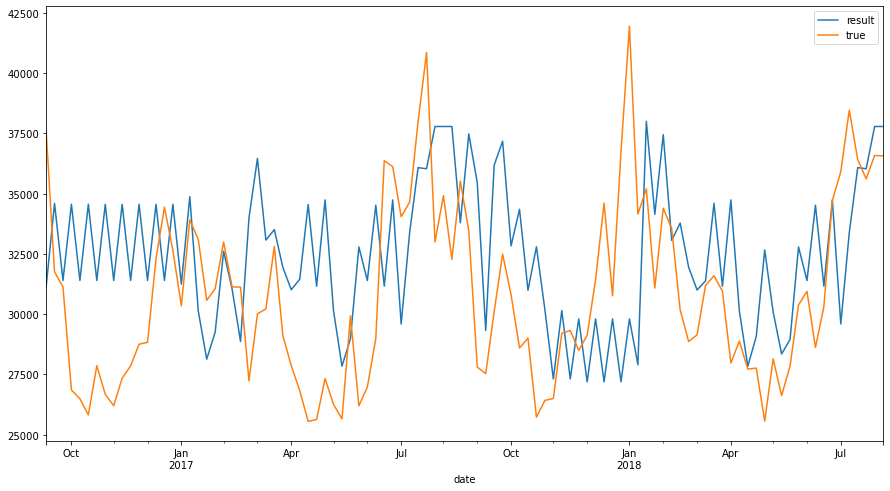

In [55]:
results[['date','result', 'true']].plot('date', figsize=(15,8))

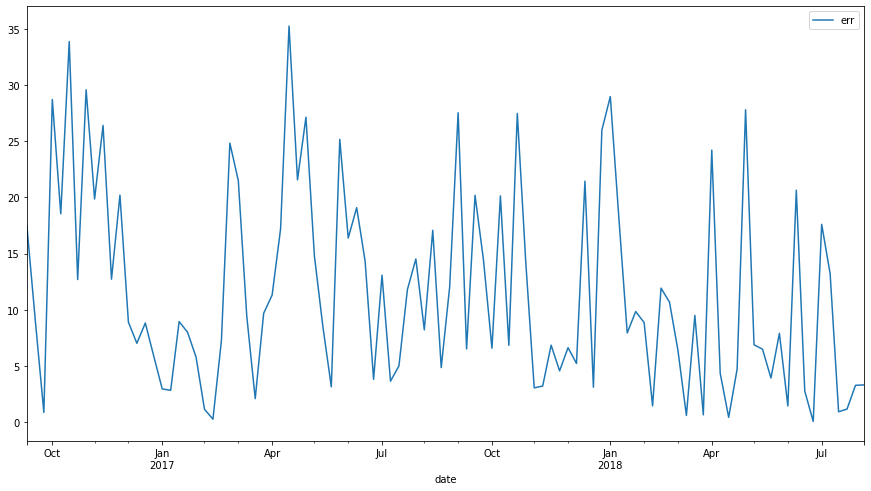

In [56]:
results[['date','err']].plot('date', figsize=(15,8))